# Getting and cleaning the data from the property price register

## 1. Getting the data

In [1]:
import pandas as pd
import requests
import numpy as np
import matplotlib.pyplot as plt
import re

In [2]:
#Link to the csv file of the property price register for Dublin, 2015
url = "https://propertypriceregister.ie/website/npsra/ppr/npsra-ppr.nsf/Downloads/PPR-2015-Dublin.csv/$FILE/PPR-2015-Dublin.csv"

#Get and save the csv as file
ppr_2015 = requests.get(url)

with open("ppr_2015.csv", "wb") as csvfile:
    csvfile.write(ppr_2015.content)

In [3]:
#make a dataframe out of the csv file
df_ppr = pd.read_csv("ppr_2015.csv", encoding="ISO-8859-1")

In [4]:
#Check 10 first rows
df_ppr.head(10)

,Date of Sale (dd/mm/yyyy),Address,Postal Code,County,Price (),Not Full Market Price,VAT Exclusive,Description of Property,Property Size Description
0,02/01/2015,"108 THE HARDWICKE VILLAGE, NORTH BRUNSWICK ST,...",Dublin 7,Dublin,"138,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
1,02/01/2015,"12 THE CEDARS, MONKSTOWN VALLEY, MONKSTOWN",NaN,Dublin,"270,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
2,02/01/2015,"4 SHREWSBURY, BALLSBRIDGE, DUBLIN 4",Dublin 4,Dublin,"900,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
3,03/01/2015,"46 HOLYWELL, UPR KILMACUD RD, DUBLIN 14",Dublin 14,Dublin,"592,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
4,04/01/2015,"73 FORBES QUAY, DUBLIN",Dublin 2,Dublin,"422,500.00",No,No,Second-Hand Dwelling house /Apartment,NaN
5,05/01/2015,"12 VILLA PARK AVE, NAVAN RD, DUBLIN 7",Dublin 7,Dublin,"510,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
6,05/01/2015,"147 OWENS AVE, CEANNT FORT, KILMAINHAM DUBLIN 8",Dublin 8,Dublin,"306,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
7,05/01/2015,"16 THE HEIGHTS, ROBSWALL, MALAHIDE",NaN,Dublin,"650,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
8,05/01/2015,"167 CRUISE PARK DR, TYRELLSTOWN, DUBLIN 15",Dublin 15,Dublin,"160,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN
9,05/01/2015,"2 LINNETFIELDS COURT, CASTAHEANY, CLONEE",Dublin 15,Dublin,"142,000.00",No,No,Second-Hand Dwelling house /Apartment,NaN


## 2. Preparing the data quality report

### Checking the data types

In [5]:
df_ppr.dtypes

Date of Sale (dd/mm/yyyy)    object
Address                      object
Postal Code                  object
County                       object
Price ()                    object
Not Full Market Price        object
VAT Exclusive                object
Description of Property      object
Property Size Description    object
dtype: object

### First trim of the data

In [6]:
#Rename "price" column to give it a more meaningful name
df_ppr = df_ppr.rename(columns= {'Price (\x80)':'Price'})

In [7]:
#Convert the property prices to floats
for i,line in enumerate(df_ppr['Price']):
    line = line.replace(",","")
    line = line.replace("\x80","")
    line = float(line)
    df_ppr.set_value(i, "Price", line)

### Assign selected data type to features

In [8]:
categorical_features = ["Postal Code", "County", "Not Full Market Price", "VAT Exclusive", "Description of Property", "Property Size Description"]
continuous_features = ["Price"]

for feature in categorical_features:
    df_ppr[feature] = df_ppr[feature].astype('category')

for feature in continuous_features:
    df_ppr[feature] = df_ppr[feature].astype('float64')


### Compile data quality report

In [9]:
#Check shape of the table
df_ppr.shape

(15316, 9)

In [10]:
#Check data quality reports
df_ppr.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,15316.0,351559.229022,503222.64974,5500.0,189427.31,270000.0,400000.0,35045714.0


In [11]:
#check types
df_ppr.dtypes

Date of Sale (dd/mm/yyyy)      object
Address                        object
Postal Code                  category
County                       category
Price                         float64
Not Full Market Price        category
VAT Exclusive                category
Description of Property      category
Property Size Description    category
dtype: object

In [12]:
df_ppr.select_dtypes(['category']).describe().T

,count,unique,top,freq
Postal Code,10477,22,Dublin 15,1313
County,15316,1,Dublin,15316
Not Full Market Price,15316,2,No,14690
VAT Exclusive,15316,2,No,13190
Description of Property,15316,3,Second-Hand Dwelling house /Apartment,13157
Property Size Description,2158,3,greater than or equal to 38 sq metres and less...,1746


## 3. Prepare data quality plan

### Calculate outliers for continuous features

In [13]:
#Calculation of the interquartile range (IDR):

q1 = df_ppr['Price'].quantile(0.25)
q3 = df_ppr['Price'].quantile(0.75)
iqr = q3 - q1

#Calculation of outliers
lower_outlier_bound = q1 - 1.5 * iqr
higher_outlier_bound = q3 + 1.5 * iqr

print("Feature: price")
print("Lower bound:", lower_outlier_bound)
print("Higher bound:", higher_outlier_bound)

Feature: price
Lower bound: -126431.725
Higher bound: 715859.035


### Prepare data quality plan


Feature                   | Data quality issue | Possible handling strategies             |
--------------------------|--------------------|------------------------------------------|
Price                     | Outliers (high)    | Clamping                                 
Postal code               | Missing values     | Search for missing values, then drop missing instances
County                    | low cardinality    | Drop feature                             
Property size description | missing values     | Drop features   


Reasoning:

* The choice was made to clamp outliers. We understand that they are good data, but they would distort our metrics too much, so we decided to clamp them

* We decided to drop instances where values were missing for 'Postal Code'. Due to the nature of that feature (which is categorical), it was not possible infer the missing values, or to replace them with another one.

## 4. Clean data

### Get missing data from postal code (where possible)

In [14]:
regex_expression = re.compile("(Dublin)\s[0-9]{1,2}|(DUBLIN)\s[0-9]{1,2}|(dublin)\s[0-9]{1,2}")

#Converting to object as otherwise it raises an error:
#ValueError: Cannot setitem on a Categorical with a new category, set the categories first
df_ppr['Postal Code'] = df_ppr['Postal Code'].astype('object')

count_retrieved = 0

for i, line in enumerate(df_ppr['Address']):
    #Check missing postcode;
    # this works because (nan) is a float; cannot use np.isnan on type string
    if type(df_ppr['Postal Code'][i]) == float:
        #Check for postal code in address
        postal_code = regex_expression.search(line)
        if postal_code != None:
            count_retrieved += 1
            #replace postal code
            df_ppr.set_value(i, 'Postal Code', postal_code.group().title())

print("Could retrieve", count_retrieved, "missing values")

#Convert back to category
df_ppr['Postal Code'] = df_ppr['Postal Code'].astype('category')

Could retrieve 813 missing values


### Drop missing instances (Postal code)

In [15]:
nb_rows_before_drop = df_ppr.shape[0]

#Drop rows where postal code is missing
df_ppr = df_ppr.dropna(subset=['Postal Code'])

new_nb_rows = df_ppr.shape[0]

In [16]:
print("Total row loss =", (nb_rows_before_drop - new_nb_rows) / nb_rows_before_drop * 100, "%")

Total row loss = 26.286236615304258 %


### Drop features with low cardinality

In [17]:
df_ppr = df_ppr.drop('County', 1)
df_ppr = df_ppr.drop('Property Size Description', 1)

In [18]:
df_ppr.head(10)

,Date of Sale (dd/mm/yyyy),Address,Postal Code,Price,Not Full Market Price,VAT Exclusive,Description of Property
0,02/01/2015,"108 THE HARDWICKE VILLAGE, NORTH BRUNSWICK ST,...",Dublin 7,138000.0,No,No,Second-Hand Dwelling house /Apartment
2,02/01/2015,"4 SHREWSBURY, BALLSBRIDGE, DUBLIN 4",Dublin 4,900000.0,No,No,Second-Hand Dwelling house /Apartment
3,03/01/2015,"46 HOLYWELL, UPR KILMACUD RD, DUBLIN 14",Dublin 14,592000.0,No,No,Second-Hand Dwelling house /Apartment
4,04/01/2015,"73 FORBES QUAY, DUBLIN",Dublin 2,422500.0,No,No,Second-Hand Dwelling house /Apartment
5,05/01/2015,"12 VILLA PARK AVE, NAVAN RD, DUBLIN 7",Dublin 7,510000.0,No,No,Second-Hand Dwelling house /Apartment
6,05/01/2015,"147 OWENS AVE, CEANNT FORT, KILMAINHAM DUBLIN 8",Dublin 8,306000.0,No,No,Second-Hand Dwelling house /Apartment
8,05/01/2015,"167 CRUISE PARK DR, TYRELLSTOWN, DUBLIN 15",Dublin 15,160000.0,No,No,Second-Hand Dwelling house /Apartment
9,05/01/2015,"2 LINNETFIELDS COURT, CASTAHEANY, CLONEE",Dublin 15,142000.0,No,No,Second-Hand Dwelling house /Apartment
10,05/01/2015,"243 SEAPARK, MALAHIDE, DUBLIN",Dublin 3,740000.0,No,No,Second-Hand Dwelling house /Apartment
11,05/01/2015,"25 NEW ROW SQ, NEW ROW SOUTH, DUBLIN 8",Dublin 8,270000.0,No,No,Second-Hand Dwelling house /Apartment


### Clamp outliers

In [19]:
for i in df_ppr.index:
    price = df_ppr['Price'][i]
    if price > higher_outlier_bound:
        df_ppr.set_value(i, 'Price', higher_outlier_bound)

In [20]:
df_ppr.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,11290.0,305076.479721,171162.0318,5500.0,180000.0,259955.95,385000.0,715859.035


## 5. Analyze the data

### Breakdown statistics per area

In [21]:
#Check Dublin postal codes
df_ppr['Postal Code'].cat.categories

Index(['Dublin 1', 'Dublin 10', 'Dublin 11', 'Dublin 12', 'Dublin 13',
       'Dublin 14', 'Dublin 15', 'Dublin 16', 'Dublin 17', 'Dublin 18',
       'Dublin 2', 'Dublin 20', 'Dublin 22', 'Dublin 24', 'Dublin 3',
       'Dublin 4', 'Dublin 5', 'Dublin 6', 'Dublin 6w', 'Dublin 7', 'Dublin 8',
       'Dublin 9'],
      dtype='object')

In [22]:
#Make statistics per areas
stats_per_area = df_ppr.groupby('Postal Code').describe()

stats_per_area

Price
Postal Code                     
Dublin 1    count     451.000000
            mean   201949.861098
            std    123443.163126
            min     10000.000000
            25%    130000.000000
            50%    179000.000000
            75%    250000.000000
            max    715859.035000
Dublin 10   count     142.000000
            mean   135896.414859
            std     47680.651506
            min      8890.000000
            25%     95500.000000
            50%    150000.000000
            75%    165000.000000
            max    255000.000000
Dublin 11   count     544.000000
            mean   201739.526406
            std    109233.364765
            min     12500.000000
            25%    132159.000000
            50%    176167.695000
            75%    250000.000000
            max    715859.035000
Dublin 12   count     484.000000
            mean   253738.881560
            std     97139.320683
            min     16000.000000
            25%    191187.500000
            50%    239500.000000
...                          ...
Dublin 6w   std    129226.141209
            min    100000.000000
            25%    546256.000000
            50%    570900.000000
            75%    630000.000000
            max    715859.035000
Dublin 7    count     693.000000
            mean   258119.747821
            std    108249.103704
            min     46716.430000
            25%    187000.000000
            50%    241000.000000
            75%    318500.000000
            max    715859.035000
Dublin 8    count     727.000000
            mean   242447.110935
            std    136716.175055
            min     10000.000000
            25%    157709.000000
            50%    213890.000000
            75%    280000.000000
            max    715859.035000
Dublin 9    count     690.000000
            mean   271456.228862
            std    144874.675989
            min     17000.000000
            25%    147132.000000
            50%    250000.000000
            75%    350000.000000
            max    715859.035000

[176 rows x 1 columns]

In [23]:
#Merge category 'Dublin 6 w' with category 'Dublin' since there is only ~30 houses with category 'Dublin 6w'

df_ppr['Postal Code'][df_ppr['Postal Code'] == 'Dublin 6w'] = 'Dublin 6'
df_ppr['Postal Code'] = df_ppr['Postal Code'].cat.remove_unused_categories()

In [24]:
#Re-generate and save the report

stats_per_area = df_ppr.groupby('Postal Code').describe()

stats_per_area.to_csv('housing_price_per_area.csv')

stats_per_area

Price
Postal Code                     
Dublin 1    count     451.000000
            mean   201949.861098
            std    123443.163126
            min     10000.000000
            25%    130000.000000
            50%    179000.000000
            75%    250000.000000
            max    715859.035000
Dublin 10   count     142.000000
            mean   135896.414859
            std     47680.651506
            min      8890.000000
            25%     95500.000000
            50%    150000.000000
            75%    165000.000000
            max    255000.000000
Dublin 11   count     544.000000
            mean   201739.526406
            std    109233.364765
            min     12500.000000
            25%    132159.000000
            50%    176167.695000
            75%    250000.000000
            max    715859.035000
Dublin 12   count     484.000000
            mean   253738.881560
            std     97139.320683
            min     16000.000000
            25%    191187.500000
            50%    239500.000000
...                          ...
Dublin 6    std    191951.793885
            min     60000.000000
            25%    290749.000000
            50%    445000.000000
            75%    660793.000000
            max    715859.035000
Dublin 7    count     693.000000
            mean   258119.747821
            std    108249.103704
            min     46716.430000
            25%    187000.000000
            50%    241000.000000
            75%    318500.000000
            max    715859.035000
Dublin 8    count     727.000000
            mean   242447.110935
            std    136716.175055
            min     10000.000000
            25%    157709.000000
            50%    213890.000000
            75%    280000.000000
            max    715859.035000
Dublin 9    count     690.000000
            mean   271456.228862
            std    144874.675989
            min     17000.000000
            25%    147132.000000
            50%    250000.000000
            75%    350000.000000
            max    715859.035000

[168 rows x 1 columns]

In [25]:
#Read the new csv file
df_areas = pd.read_csv('housing_price_per_area.csv')

In [26]:
df_areas

,Postal Code,Unnamed: 1,Price
0,Dublin 1,count,451.000000
1,Dublin 1,mean,201949.861098
2,Dublin 1,std,123443.163126
3,Dublin 1,min,10000.000000
4,Dublin 1,25%,130000.000000
5,Dublin 1,50%,179000.000000
6,Dublin 1,75%,250000.000000
7,Dublin 1,max,715859.035000
8,Dublin 10,count,142.000000
9,Dublin 10,mean,135896.414859


### Categorize areas from least wealthy to most wealthy

In [27]:
#Make a new data frame with the median price of houses
df_median_areas = df_areas[df_areas['Unnamed: 1'] == '50%']

In [28]:
df_median_areas

,Postal Code,Unnamed: 1,Price
5,Dublin 1,50%,179000.000
13,Dublin 10,50%,150000.000
21,Dublin 11,50%,176167.695
29,Dublin 12,50%,239500.000
37,Dublin 13,50%,274995.000
45,Dublin 14,50%,450000.000
53,Dublin 15,50%,238000.000
61,Dublin 16,50%,395000.000
69,Dublin 17,50%,132787.000
77,Dublin 18,50%,255000.000


In [29]:
df_median_areas.describe().T

,count,mean,std,min,25%,50%,75%,max
Price,21.0,270897.128333,99359.14385,132787.0,200000.0,242000.0,315000.0,475000.0


#### General findings:

In [30]:
median_q1 = df_median_areas['Price'].quantile(0.25)
median_median = df_median_areas['Price'].quantile(0.5)
median_q3 = df_median_areas['Price'].quantile(0.75)

print('Least wealthy areas (below 1st quartile:)')
print(df_median_areas['Postal Code'][df_median_areas['Price'] <= median_q1])

print()
print('Relatively unwealty areas (below median):')
print(df_median_areas['Postal Code'][(df_median_areas['Price'] > median_q1) & (df_median_areas['Price'] <= median_median)])

print()
print('Relatively wealthy areas (below 3rd quartile):')
print(df_median_areas['Postal Code'][(df_median_areas['Price'] > median_median) & (df_median_areas['Price'] <= median_q3)])

print()
print('Wealthiest areas (above 3rd quartile):')
print(df_median_areas['Postal Code'][df_median_areas['Price'] > median_q3])

Least wealthy areas (below 1st quartile:)
5       Dublin 1
13     Dublin 10
21     Dublin 11
69     Dublin 17
101    Dublin 22
109    Dublin 24
Name: Postal Code, dtype: object

Relatively unwealty areas (below median):
29     Dublin 12
53     Dublin 15
93     Dublin 20
149     Dublin 7
157     Dublin 8
Name: Postal Code, dtype: object

Relatively wealthy areas (below 3rd quartile):
37     Dublin 13
77     Dublin 18
85      Dublin 2
133     Dublin 5
165     Dublin 9
Name: Postal Code, dtype: object

Wealthiest areas (above 3rd quartile):
45     Dublin 14
61     Dublin 16
117     Dublin 3
125     Dublin 4
141     Dublin 6
Name: Postal Code, dtype: object


In [31]:
#saving report to csv

df_median_areas = df_median_areas.reset_index(drop=True)
df_median_areas = df_median_areas.drop("Unnamed: 1", 1)
df_median_areas["wealth category"] = "N/A"

for i in range(df_median_areas.shape[0]):
    if df_median_areas["Price"].iloc[i] <= median_q1:
        df_median_areas.set_value(i,"wealth category", "unwealthy")
    elif df_median_areas["Price"].iloc[i] <= median_median:
        df_median_areas.set_value(i,"wealth category", "relatively unwealthy")
    elif df_median_areas["Price"].iloc[i] <= median_q3:
        df_median_areas.set_value(i,"wealth category", "relatively wealthy")
    else:
        df_median_areas.set_value(i,"wealth category", "wealthy")

df_median_areas = df_median_areas.rename(columns={"Price":"Median housing price"})

df_median_areas.to_csv("median_housing_price_per_area.csv")

## 6. Graphical representation

### Average housing price per areas

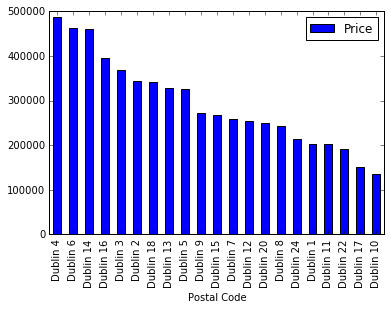

In [32]:
%matplotlib inline

df_ppr[["Postal Code", "Price"]].groupby("Postal Code").mean().sort_values(by='Price', ascending=False).plot(kind="bar")

### Housing sale count per areas

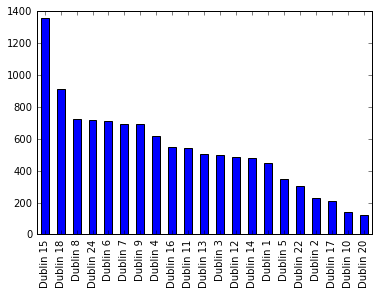

In [33]:
df_ppr["Postal Code"].value_counts().plot(kind="bar")

### Median housing price per wealth category

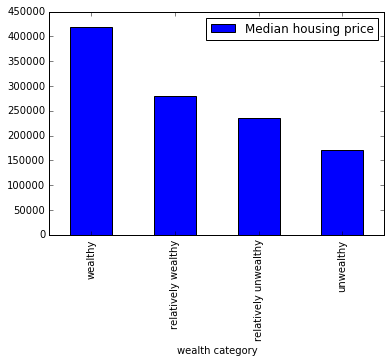

In [34]:
df_median_areas[["wealth category", "Median housing price"]].groupby("wealth category").mean().sort_values(by='Median housing price', ascending=False).plot(kind="bar")